In [2]:
import numpy as np 
import pandas as pd 
import cv2
import random
from tqdm import tqdm
#from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
#To import the necessary files
import os
for dirname, _, filenames in os.walk('./data/cataract/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/cataract/.gitkeep
./data/cataract/full_df.csv
./data/cataract/ODIR-5K\data.xlsx
./data/cataract/ODIR-5K\Testing Images\1000_left.jpg
./data/cataract/ODIR-5K\Testing Images\1000_right.jpg
./data/cataract/ODIR-5K\Testing Images\1001_left.jpg
./data/cataract/ODIR-5K\Testing Images\1001_right.jpg
./data/cataract/ODIR-5K\Testing Images\1002_left.jpg
./data/cataract/ODIR-5K\Testing Images\1002_right.jpg
./data/cataract/ODIR-5K\Testing Images\1003_left.jpg
./data/cataract/ODIR-5K\Testing Images\1003_right.jpg
./data/cataract/ODIR-5K\Testing Images\1004_left.jpg
./data/cataract/ODIR-5K\Testing Images\1004_right.jpg
./data/cataract/ODIR-5K\Testing Images\1007_left.jpg
./data/cataract/ODIR-5K\Testing Images\1007_right.jpg
./data/cataract/ODIR-5K\Testing Images\1009_left.jpg
./data/cataract/ODIR-5K\Testing Images\1009_right.jpg
./data/cataract/ODIR-5K\Testing Images\1026_left.jpg
./data/cataract/ODIR-5K\Testing Images\1026_right.jpg
./data/cataract/ODIR-5K\Testing Images\1027_left.jpg
./da

In [5]:
#To create df for analysis
df = pd.read_csv("./data/cataract/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


In [6]:
#Cataract binary classification
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [7]:
#Conversion
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [8]:
#Left eye Cataract images
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [9]:
#Right eye Cataract images
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [10]:
#To print the total number of left eye cataract and right eye cataract images
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [11]:
#Normal eye sample images (right eye and left eye)
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [12]:
#Concatenating all cataract eye images and normal eye images individually
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [13]:
print(len(cataract),len(normal))

594 500


In [14]:
#Image to numpy array
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "./data/cataract/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [15]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [00:04<00:00, 147.87it/s]


In [16]:
len(dataset)

588

In [17]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:07<00:00, 68.78it/s]


In [18]:
len(dataset)

1088

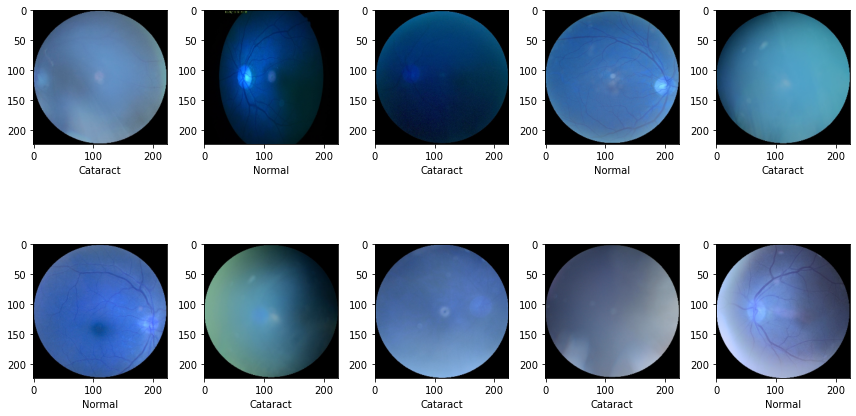

In [19]:
#Display the first 10 normal and category eye images 
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [20]:
#Defining x and y variables
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [21]:
#Train, test and split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [22]:
#Define VGG19
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80142336/80134624 [==============================] - 11s 0us/step


In [23]:
'''Layers & models also feature a boolean attribute trainable. Its value can be changed. Setting layer.trainable 
to False moves all the layer's weights from trainable to non-trainable. This is called "freezing" the layer: the 
state of a frozen layer won't be updated during training (either when training with fit() or when training 
with any custom loop that relies on trainable_weights to apply gradient updates).'''

for layer in vgg.layers:
    layer.trainable = False

In [24]:
#Defining the model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [26]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [28]:
#Model fitting
history = model.fit(x_train,y_train,batch_size=32,epochs=8,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/8
28/28 [==============================] - 280s 10s/step - loss: 1.1541 - accuracy: 0.9057 - val_loss: 0.6120 - val_accuracy: 0.9404
Epoch 2/8
28/28 [==============================] - 607s 22s/step - loss: 0.1212 - accuracy: 0.9747 - val_loss: 0.6131 - val_accuracy: 0.9450
Epoch 3/8
28/28 [==============================] - 309s 11s/step - loss: 0.0294 - accuracy: 0.9908 - val_loss: 0.6279 - val_accuracy: 0.9495
Epoch 4/8
28/28 [==============================] - 318s 11s/step - loss: 0.0175 - accuracy: 0.9920 - val_loss: 0.7878 - val_accuracy: 0.9587
Epoch 5/8
28/28 [==============================] - 783s 29s/step - loss: 0.0345 - accuracy: 0.9943 - val_loss: 0.9231 - val_accuracy: 0.9450
Epoch 6/8
28/28 [==============================] - 248s 9s/step - loss: 0.0253 - accuracy: 0.9908 - val_loss: 0.7752 - val_accuracy: 0.9495
Epoch 7/8
28/28 [==============================] - 248s 9s/step - loss: 0.0065 - accuracy: 0.9966 - val_loss: 0.7579 - val_accuracy: 0.9633
Epoch 8/8
28/28

In [29]:
#To evaluate the loss and accuracy values
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 49s 7s/step - loss: 0.6598 - accuracy: 0.9495
loss: 0.6597530841827393
Accuracy: 0.9495412707328796


In [30]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict_classes(x_test)

C:\Users\91963\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [31]:
#Accuracy
accuracy_score(y_test,y_pred)

0.9495412844036697

In [32]:
#To print the classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       109
           1       0.95      0.94      0.95       109

    accuracy                           0.95       218
   macro avg       0.95      0.95      0.95       218
weighted avg       0.95      0.95      0.95       218



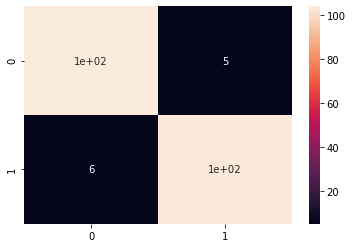

In [33]:
'''from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);
                  '''
#Plotting the confusion matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True)

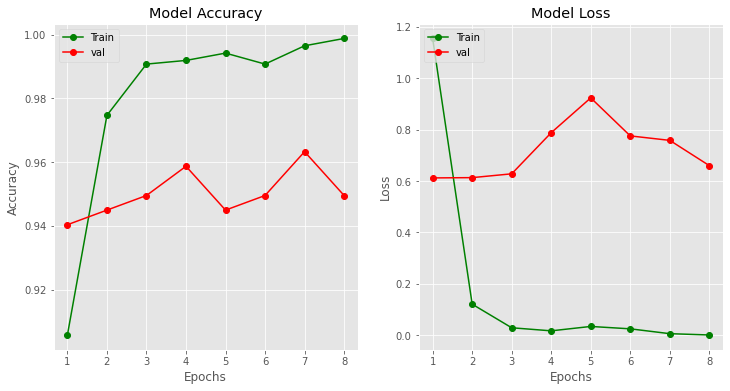

In [34]:
#To plot the model accuracy and model loss after each epoch
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,9)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

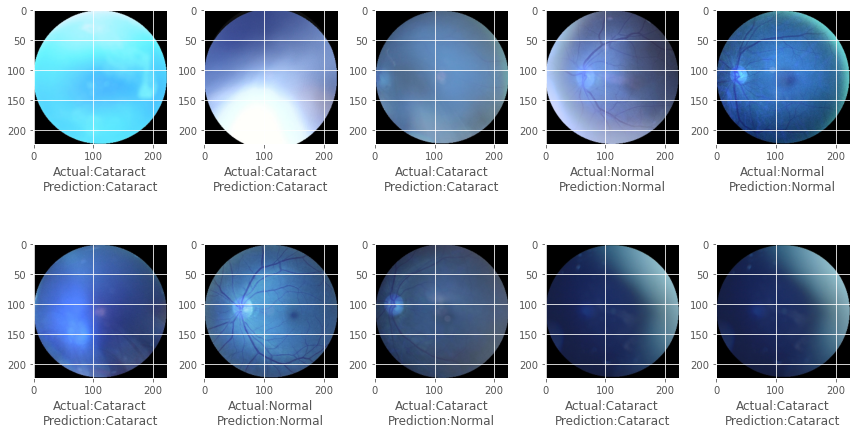

In [35]:
#Actual vs Prediction
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()